In [8]:
% matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import cv2
from skimage import transform

In [6]:
def rescaling(image):
    max_dimension = max(image.shape)
    scale= 640.0/max_dimension
    image = cv2.resize(image,None,fx=scale,fy=scale,interpolation = cv2.INTER_AREA)
    return image

In [ ]:
import glob
images = [rescaling(cv2.imread(file)) for file in glob.glob("./Desktop/test_images/*")]

In [4]:
def printImage(image):
    cv2.imshow('image',image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

In [5]:
def printAndCompare(image1,image2):
# numpy_horizontal = np.hstack((image, grey_3_channel))
    concatenateHorizontal = np.concatenate((image1,image2),axis = 1)
    cv2.imshow('concatenateHor',concatenateHorizontal)
    k=cv2.waitKey(0)
    cv2.destroyAllWindows()
    return k

In [1]:
#using blob detection
from skimage.feature import blob_dog, blob_log, blob_doh
from math import sqrt
test_img = images[0]
image_gray = cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)

# difference of guassian blob detection 
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)

blobs = [blobs_dog]
colors = ['red']
titles = ['Difference of Gaussian']
sequence = zip(blobs, colors, titles)

for blobs, color, title in sequence:
    fig, ax = plt.subplots(1, 1)
    ax.set_title(title)
    ax.imshow(image, interpolation='nearest')
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=1, fill=False)
        ax.add_patch(c)

plt.tight_layout()
plt.show()

NameError: name 'rescaling' is not defined

# image -> binarisation using masking(by selecting the min and max range of hsv channel) -> morphological transformation to remove the noise -> corner detection using harris corner -> using box filter to merge the corners

In [ ]:
img = images[0]
gray= cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)

# masking image for separating the grid portion
image_hsv = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
min_val = np.array([0,0,0],np.uint8)
max_val = np.array([255,120,120],np.uint8)
mask = cv2.inRange(image_hsv,min_val,max_val)
#inverting the mask
invert_masked = cv2.bitwise_not(mask)
printAndCompare(gray,invert_masked)
#boolean and with the original image
invertMaskedColored = cv2.cvtColor(invert_masked,cv2.COLOR_GRAY2RGB)
maskedImage = cv2.bitwise_and(img,invertMaskedColored)
finalMasked = cv2.addWeighted(maskedImage,1,invertMaskedColored,0,1)
# printImage(masked_image)
#checking if blurring improves the result from successive morphological transformation 
blur = cv2.GaussianBlur(masked_image,(5,5),0.5,0.5)
printImage(blur)
kernel =  cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
closing = cv2.morphologyEx(finalMasked, cv2.MORPH_CLOSE, kernel)
printImage(closing)
# applying harris corner detection
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
#passing the smooth image for corner detection
blur = cv2.GaussianBlur(gray,(7,7),0.5,0.5)

harrisCorner = cv2.cornerHarris(blur,2,3,0.04)
# print dst.shape
harrisCorner = cv2.dilate(dst,None)
#thresholding corners as 25 percent of max quality 
img[harrisCorner>0.025*harrisCorner.max()]=[0,0,255]

cv2.boxFilter(img, -1, (3,3), img, (-1,-1), False, cv2.BORDER_DEFAULT)
# cv2.imwrite('harrisCorners_one.png',img)
printImage(img)
# cv2.imwrite('blurredCorner.png',img)  img , k = tuneParameter(equalized,img,sizeBlock,sizeKernel,3)

In [6]:
#selecting optimal block_size, kernel_size, boxFilter, quality parameter
def tuneParameter(img,block_size,kernel_size,boxFilter_size,quality):
    eigenVals = cv2.cornerEigenValsAndVecs(img, block_size, kernel_size, cv2.BORDER_DEFAULT)
    edgeDensity = ((eigenVals[:,:,0]-eigenVals[:,:,1])**2)/((eigenVals[:,:,0]+eigenVals[:,:,1])**2+0.002)
    edgeDensity = cv2.dilate(edgeDensity,None)    
    normalizedEdgeDensity = cv2.normalize(edgeDensity, 0.0, 1.0, cv2.NORM_MINMAX)
    test_img2 = test_img.copy()
    test_img2[normalizedEdgeDensity>quality*normalizedEdgeDensity.max()]=[0,255,0]
    cv2.boxFilter(test_img2, -1, (boxFilter_size,boxFilter_size), test_img2, (-1,-1), False, cv2.BORDER_DEFAULT)
    k = printAndCompare(test_img,test_img2)
    return k,test_img2

In [9]:
test_img = images[0]
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
#image histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
equalized = clahe.apply(gray)
printImage(equalized)
desired_blockSize = []
desired_kernelSize = []
desired_filterSize = []
block_size = [i for i in range(4,10)] # size = 10
kernel_size = [j for j in range(3,11,2)] 
filter_size = [k for k in range(3,8)]
quality_factor = [m*0.1 for m in range(8,3,-1)]
count = 0
#iterating over a range of each values to select for the selected image and test those range parameters on other image
for sizeBlock in block_size:
    for sizeKernel in kernel_size:
        for sizeFilter in filter_size:
            for quality in quality_factor:
                k,img = tuneParameter(equalized,sizeBlock,sizeKernel,sizeFilter,quality)
                if k ==27:   #if key pressed is ESC 
                    count += 1 
                    desired_blockSize.append(sizeBlock)
                    desired_kernelSize.append(sizeKernel)
                    desired_filterSize.append(sizeFilter)
                    imageName = 'test_img' + str(count) + '.png'
                    cv2.imwrite(imageName,img)

In [ ]:
filtered_kernelSize = []
filtered_filterSize = []
filtered_blockSize = []
for sizeBlock in desired_blockSize:
    for sizeKernel in desired_kernelSize:
        for sizeFilter in desired_filterSize:
            for quality in quality_factor:
                k,img = tuneParameter(equalized,sizeBlock,sizeKernel,sizeFilter,quality)
                if k ==27:
                    count += 1 
                    filered_blockSize.append(sizeBlock)
                    filtered_kernelSize.append(sizeKernel)
                    filtered_filterSize.append(sizeFilter)
                    imageName = 'test_img' + str(count) + '.png'
                    cv2.imwrite(imageName,img)

32

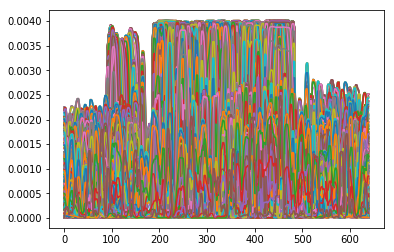

In [22]:
# test code for selecting the range to vary parameters for edge and corner detected image 
test_img = rescaling(image)
gray = cv2.cvtColor(test_img,cv2.COLOR_BGR2GRAY)
blur = cv2.GaussianBlur(gray,(5,5),3,3)
#histogram equalization
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(4,4))
equalized = clahe.apply(gray)
# printImage(equalized)
harrisCorner = cv2.cornerHarris(equalized,10,3,0.04)
## as kernel size is increased the detected edges increases
eigenVals = cv2.cornerEigenValsAndVecs(blur, 7, 5, cv2.BORDER_DEFAULT)
harrisCorner = cv2.dilate(harrisCorner,None)
# 6 channels two eigen values , corresponding eigen vectors

edgeDensity = ((eigenVals[:,:,0]-eigenVals[:,:,1])**2)/((eigenVals[:,:,0]+eigenVals[:,:,1])**2+0.002)
edgeDensity = cv2.dilate(edgeDensity,None)
normalizedEdgeDensity = cv2.normalize(edgeDensity, 0.0, 1.0, cv2.NORM_MINMAX)

## plotting edgeDensity distribution 
plt.plot(normalizedEdgeDensity)
plt.show
#test_img1 with marked detected corner
#test_img2 with marked detected corner
test_img1 = test_img.copy()
test_img2 = test_img.copy()
#selecting quality level as min 0.02 of max value of R parameter[R=abs(eigenVal1*eigenVal2-(eigenVal1+eigenVal2))]  
#quality level for detected edges as 0.8 of max value
test_img1[harrisCorner>0.02*harrisCorner.max()] = [255,0,0]
test_img2[normalizedEdgeDensity>0.8*normalizedEdgeDensity.max()]=[0,255,0]
# # printImage(equalized)
#applying box filter on edges detected image(test_img2) and corner detected image(test_img1)
cv2.boxFilter(test_img1, -1, (5,5), test_img1, (-1,-1), False, cv2.BORDER_DEFAULT)
cv2.boxFilter(test_img2, -1, (5,5), test_img2, (-1,-1), False, cv2.BORDER_DEFAULT)
# printImage(test_img2)
printAndCompare(test_img,test_img2)
saliencyMap = cv2.addWeighted(test_img1,1,test_img2,1,0)

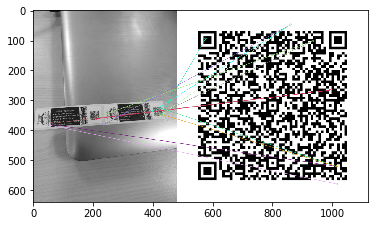

(<matplotlib.image.AxesImage at 0x7f83480ae0d0>, None)

In [9]:
#using keypoint descriptors(Scale invariant feature) matching 
img1 = cv2.imread('/home/shanu/Desktop/test_images/image.jpeg',0)
img2 = cv2.imread('/home/shanu/Desktop/image1.png',0)          # queryImage
img1 = rescaling(img1)
img2 = rescaling(img2)
sift1 = cv2.xfeatures2d.SIFT_create()
(kps1, descs1) = sift1.detectAndCompute(img1, None)
sift2 = cv2.xfeatures2d.SIFT_create()
(kps2, descs2) = sift2.detectAndCompute(img2, None)
#create object of matcher
bf = cv2.BFMatcher()  #brute force matcher to compare feature keypoints of one image with test image
matches = bf.knnMatch(descs1,descs2, k=2)  # k best features 
# Apply ratio test
goodMatches = []
for m,n in matches:
    if m.distance < 0.75*n.distance:
        goodMatches.append([m])
# cv2.drawMatchesKnn expects list of lists as matches.
img2 = cv2.drawMatchesKnn(img1,kps1,img2,kps2,goodMatches,img2,flags=2)  # drawing the selected matchpoints on out image img2
plt.imshow(img2),plt.show()
## drawing all the detected keypoints(Sift features) of image 
# img = cv2.drawKeypoints(gray, kps, img, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
# cv2.imwrite('keyPoint.png',img)
# printImage(img2)
# print type(kps)

In [ ]:
#selecting the range of hsv values for masking the image for qr grid
img = rescaling(image)
hsv_image = cv2.cvtColor(img,cv2.COLOR_BGR2HSV)
printImage(hsv_image)
hue_channel = hsv_image[:,:,0]
sat_channel = hsv_image[:,:,1]
print np.max(sat_channel)
val_channel = hsv_image[:,:,2]
print np.max(val_channel)
# hist2d = cv2.calcHist(hsv_image,[2,1],None,[255,255],[0,255,0,255])
# plt.imshow(hist2d,interpolation = 'nearest')
plt.plot(hist2d,'r')
plt.show
#masking based on brightness level
min_saturation = np.array([0,0,0],np.uint8)
max_saturation = np.array([180,140,100],np.uint8)
mask = cv2.inRange(hsv_image,min_saturation,max_saturation)
mask_invert = cv2.bitwise_not(mask)
printImage(mask_invert)
# mask_bgr = cv2.cvtColor(mask,cv2.COLOR_HSV2RGB)
mean_val = np.mean(val_channel)
std_val = np.std(val_channel)
mean_sat = np.mean(sat_channel)
std_sat = np.std(sat_channel)
print mean_sat,std_sat
print mean_val,std_val
